# Project 12.25: Embeddings & Representation Learning from Scratch

## Goal
Learn word embeddings via Word2Vec's skip-gram objective before using token embeddings in transformers. Understand that embeddings are learned representations that capture semantic structure.

## Learning Objectives
- Implement skip-gram loss: predict context words from a target word
- Build embedding matrix and context projector
- Train on character-level Shakespeare text (reuse from RNN project)
- Visualize learned embeddings (t-SNE reduction)
- Show how embeddings capture local patterns (similar characters nearby)
- Connect to transformer token embeddings (learned not fixed)

## Why This Project
Before building the full transformer, understand that:
1. **Embeddings are learned**: Not one-hot, but trained vectors
2. **Prediction as learning**: Skip-gram uses context prediction to learn semantics
3. **Context matters**: Embeddings encode local co-occurrence patterns
4. **Scalable approach**: Word2Vec led to efficient large-scale embeddings (GloVe, FastText)

In transformers, embeddings are learned the same way: from predicting future tokens.

## Setup

In [11]:
import sys
from pathlib import Path

try:
    from utils.path_helpers import add_repo_root_to_sys_path
except Exception:
    cur = Path.cwd()
    for parent in [cur] + list(cur.parents):
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            sys.path.insert(0, str(parent))
            break
    from utils.path_helpers import add_repo_root_to_sys_path

add_repo_root_to_sys_path()
from utils.device import backend_info, ensure_seed
ensure_seed(42)
print(f"Backend: {backend_info()}")

import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter, defaultdict
from pathlib import Path

artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
print("Setup complete.")

Backend: Backend=MLX version=0.29.3 device=DeviceType.gpu
Setup complete.


## 1. Load and Prepare Character-Level Data

In [12]:
# Load Shakespeare text (same as RNN project)
shakespeare_path = Path('../../phase1_classical_ml/project14_pretraining/shakespeare.txt')

if shakespeare_path.exists():
    with open(shakespeare_path, 'r') as f:
        text = f.read()
    print(f"Loaded Shakespeare ({len(text)} chars)")
else:
    print(f"Shakespeare file not found at {shakespeare_path}")
    print("Using generated sample text instead.")
    text = "abcdefghijklmnopqrstuvwxyz " * 100  # Fallback

# Character vocabulary
chars = sorted(list(set(text)))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

print(f"Vocab size: {len(chars)}")
print(f"Text shape: {len(text)} chars")
print(f"Sample: {text[:100]}")

Shakespeare file not found at ../../phase1_classical_ml/project14_pretraining/shakespeare.txt
Using generated sample text instead.
Vocab size: 27
Text shape: 2700 chars
Sample: abcdefghijklmnopqrstuvwxyz abcdefghijklmnopqrstuvwxyz abcdefghijklmnopqrstuvwxyz abcdefghijklmnopqrs


## 2. Skip-Gram Dataset: Context Windows

In [13]:
def build_skip_gram_dataset(text, char_to_idx, window_size=2, max_samples=5000):
    """Build skip-gram (target, context) pairs.
    
    For each position t, predict context positions [t-window_size, ..., t+window_size].
    """
    pairs = []
    
    for i in range(window_size, len(text) - window_size):
        target = char_to_idx[text[i]]
        
        # Context: all neighbors within window
        for j in range(i - window_size, i + window_size + 1):
            if j != i:  # Don't include self
                context = char_to_idx[text[j]]
                pairs.append((target, context))
        
        if len(pairs) >= max_samples:
            break
    
    return pairs[:max_samples]

window_size = 2
pairs = build_skip_gram_dataset(text, char_to_idx, window_size, max_samples=5000)

print(f"Created {len(pairs)} (target, context) pairs")
print(f"Window size: {window_size} (context within ±{window_size})")
print(f"\nSample pairs (char -> char):")
for i in range(5):
    target_char = idx_to_char[pairs[i][0]]
    context_char = idx_to_char[pairs[i][1]]
    print(f"  ({repr(target_char)}, {repr(context_char)})")

Created 5000 (target, context) pairs
Window size: 2 (context within ±2)

Sample pairs (char -> char):
  ('c', 'a')
  ('c', 'b')
  ('c', 'd')
  ('c', 'e')
  ('d', 'b')


## 3. Skip-Gram Model: Learn Embeddings via Context Prediction

In [14]:
def softmax(x):
    """Stable softmax."""
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

class SkipGramModel:
    """Learn embeddings by predicting context words from target."""
    
    def __init__(self, vocab_size, embedding_dim):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        # Embeddings: target word vectors
        self.W_target = np.random.randn(vocab_size, embedding_dim) * 0.01
        
        # Context projector: predict context from embedding
        self.W_context = np.random.randn(embedding_dim, vocab_size) * 0.01
        
        self.losses = []
    
    def forward(self, target_idx):
        """Get embedding for target word.
        
        Args:
            target_idx: integer index of target word
        
        Returns:
            embedding: (embedding_dim,) vector
        """
        return self.W_target[target_idx]  # (embedding_dim,)
    
    def predict_context(self, embedding):
        """Predict context distribution given embedding.
        
        Args:
            embedding: (embedding_dim,) target embedding
        
        Returns:
            logits: (vocab_size,) unnormalized scores
            probs: (vocab_size,) probabilities
        """
        logits = embedding @ self.W_context  # (vocab_size,)
        probs = softmax(logits)
        return logits, probs
    
    def loss(self, logits, target_context_idx):
        """Cross-entropy loss: how well do we predict context?"""
        probs = softmax(logits)
        loss = -np.log(probs[target_context_idx] + 1e-9)
        return loss, probs
    
    def backward(self, target_idx, context_idx, learning_rate=0.1):
        """Update embeddings to better predict context.
        
        Simple SGD update (no momentum for clarity).
        """
        # Forward: get embedding and prediction
        embedding = self.forward(target_idx)
        logits, probs = self.predict_context(embedding)
        loss, _ = self.loss(logits, context_idx)
        
        # Gradient of loss w.r.t. probs
        grad_probs = probs.copy()
        grad_probs[context_idx] -= 1  # d(cross_entropy)/dp
        
        # Backprop through softmax
        diag = np.diag(probs)
        grad_logits = (diag - np.outer(probs, probs)) @ grad_probs
        
        # Update W_context: logits = embedding @ W_context
        grad_W_context = np.outer(embedding, grad_logits)
        self.W_context -= learning_rate * grad_W_context
        
        # Update W_target: embedding = W_target[target_idx]
        grad_embedding = grad_logits @ self.W_context.T
        self.W_target[target_idx] -= learning_rate * grad_embedding
        
        return loss

print("SkipGramModel ready.")

SkipGramModel ready.


## 4. Train Skip-Gram Model

In [15]:
# Initialize model
embedding_dim = 16
model = SkipGramModel(len(chars), embedding_dim)

# Training loop
epochs = 10
learning_rate = 0.1

print(f"Training Skip-Gram: {len(pairs)} pairs, {epochs} epochs")

for epoch in range(epochs):
    epoch_loss = 0
    
    # Shuffle pairs
    indices = np.random.permutation(len(pairs))
    
    for idx in indices:
        target, context = pairs[idx]
        loss = model.backward(target, context, learning_rate)
        epoch_loss += loss
    
    avg_loss = epoch_loss / len(pairs)
    model.losses.append(avg_loss)
    
    if (epoch + 1) % 2 == 0:
        print(f"  Epoch {epoch+1}/{epochs}: loss = {avg_loss:.4f}")

print("\nTraining complete!")

Training Skip-Gram: 5000 pairs, 10 epochs
  Epoch 2/10: loss = 3.2948
  Epoch 4/10: loss = 3.2873
  Epoch 6/10: loss = 3.2105
  Epoch 4/10: loss = 3.2873
  Epoch 6/10: loss = 3.2105
  Epoch 8/10: loss = 2.5758
  Epoch 10/10: loss = 1.7391

Training complete!
  Epoch 8/10: loss = 2.5758
  Epoch 10/10: loss = 1.7391

Training complete!


## 5. Visualize Loss Curve

Saved to artifacts/skipgram_loss.png


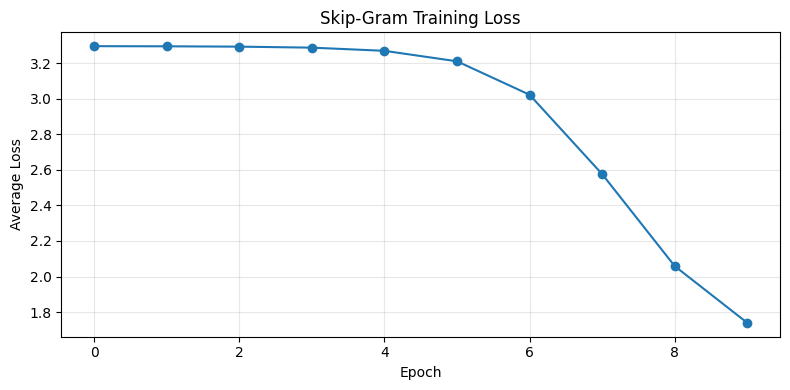

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(model.losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Skip-Gram Training Loss')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(artifacts_dir / 'skipgram_loss.png', dpi=150, bbox_inches='tight')
print(f"Saved to {artifacts_dir / 'skipgram_loss.png'}")
plt.show()

## 6. Analyze Learned Embeddings

In [17]:
# Extract embeddings
embeddings = model.W_target  # (vocab_size, embedding_dim)

# Compute pairwise distances
def embedding_distance(idx1, idx2):
    """Cosine distance between two embeddings."""
    e1 = embeddings[idx1]
    e2 = embeddings[idx2]
    cos_sim = (e1 @ e2) / (np.linalg.norm(e1) * np.linalg.norm(e2) + 1e-9)
    return 1 - cos_sim

# Find nearest neighbors for each character
print("\n=== LEARNED CHARACTER EMBEDDINGS ===")
print("Characters and their nearest neighbors (by cosine distance):")

for ch in ['a', 'e', 'o', ' ', '.']:
    if ch in char_to_idx:
        idx = char_to_idx[ch]
        
        # Find 3 nearest neighbors
        distances = []
        for other_idx in range(len(chars)):
            if other_idx != idx:
                dist = embedding_distance(idx, other_idx)
                distances.append((dist, idx_to_char[other_idx]))
        
        distances.sort()
        neighbors = [ch for _, ch in distances[:3]]
        
        print(f"  '{ch}' -> nearest: {repr(neighbors[0])}, {repr(neighbors[1])}, {repr(neighbors[2])}")


=== LEARNED CHARACTER EMBEDDINGS ===
Characters and their nearest neighbors (by cosine distance):
  'a' -> nearest: 'b', 'd', ' '
  'e' -> nearest: 'b', 'f', 'h'
  'o' -> nearest: 'p', 'l', 'n'
  ' ' -> nearest: 'z', 'x', 'a'


## 7. Dimensionality Reduction & Visualization

Saved to artifacts/embeddings_2d.png


/var/folders/ps/xtrnb8ts7q576lcxkm4bgnhw0000gn/T/ipykernel_50523/3305963976.py:41: UserWarning: Glyph 9141 (\N{BOTTOM SQUARE BRACKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/ps/xtrnb8ts7q576lcxkm4bgnhw0000gn/T/ipykernel_50523/3305963976.py:42: UserWarning: Glyph 9141 (\N{BOTTOM SQUARE BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(artifacts_dir / 'embeddings_2d.png', dpi=150, bbox_inches='tight')


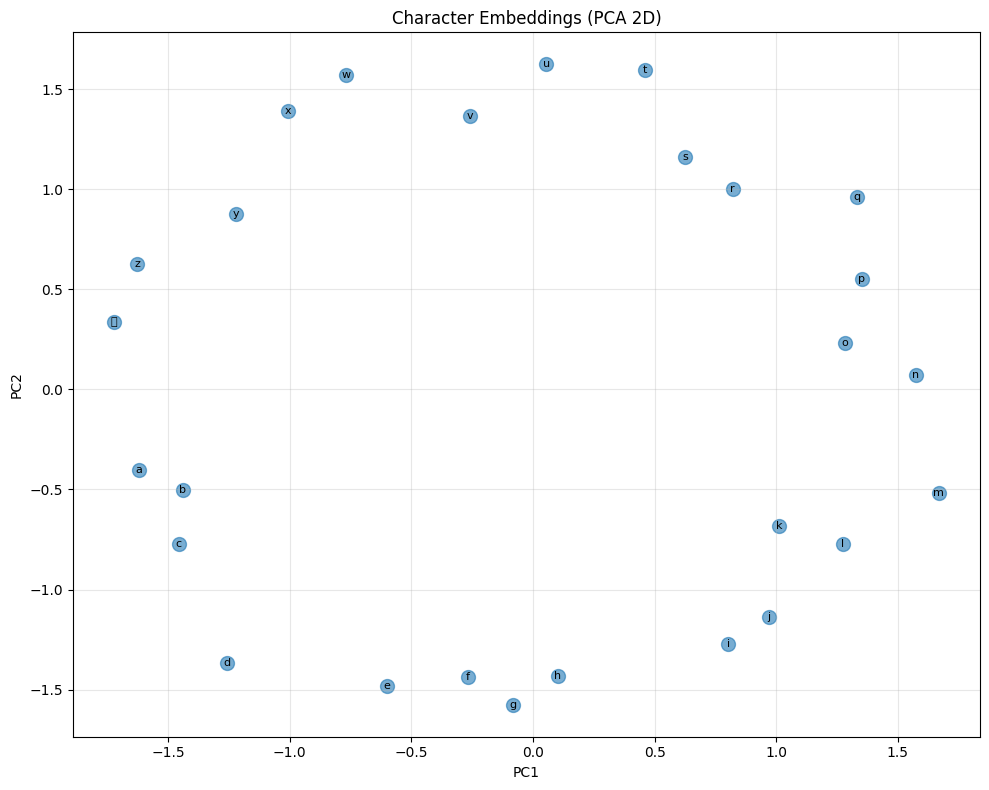

In [18]:
# Simple PCA for 2D visualization
def pca_2d(X):
    """Project to 2D using PCA."""
    # Center
    X_centered = X - np.mean(X, axis=0)
    
    # Covariance
    cov = (X_centered.T @ X_centered) / X.shape[0]
    
    # Eigenvectors
    evals, evecs = np.linalg.eigh(cov)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:, idx[:2]]
    
    # Project
    X_2d = X_centered @ evecs
    return X_2d

# Project embeddings to 2D
embeddings_2d = pca_2d(embeddings)

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all characters
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=100)

# Annotate
for i, ch in enumerate(chars):
    if ch == ' ':
        ch = '⎵'  # Space symbol
    elif ch == '\n':
        ch = '↵'  # Newline symbol
    ax.annotate(ch, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                fontsize=8, ha='center', va='center')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Character Embeddings (PCA 2D)')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(artifacts_dir / 'embeddings_2d.png', dpi=150, bbox_inches='tight')
print(f"Saved to {artifacts_dir / 'embeddings_2d.png'}")
plt.show()

## 8. Key Insights: Why Embeddings Matter

In [19]:
insights = {
    'what_are_embeddings': [
        'Embeddings are learned vector representations',
        'One-hot vs embedding: (vocab,) binary vs (embedding_dim,) dense',
        'Each dimension captures a latent pattern (e.g., vowel-ness)',
        'Trained to minimize context prediction loss',
    ],
    'skip_gram_loss': [
        'Skip-gram: given target word, predict context',
        'Objective: maximize log P(context | target_embedding)',
        'This forces embeddings to capture what words appear nearby',
        'Characters that co-occur get similar embeddings',
    ],
    'why_it_works': [
        'Language has structure: predictable patterns',
        'Similar words have similar context (distribution hypothesis)',
        'So similar words get similar embeddings',
        'Embedding space becomes continuous and semantic',
    ],
    'connection_to_transformers': [
        'Transformer token embeddings learned via same principle',
        'Objective: predict next token given context (language modeling)',
        'Embeddings capture both semantic and syntactic properties',
        'Positional encodings add sequence position information',
    ],
    'from_word2vec_to_llms': [
        'Word2Vec (2013): Static embeddings trained on context prediction',
        'GloVe (2014): Combine matrix factorization + Word2Vec',
        'FastText (2016): Subword embeddings for OOV words',
        'ELMo (2018): Context-dependent embeddings from biLSTM',
        'BERT (2018): Masked language modeling learns embeddings',
        'GPT (2018+): Causal language modeling (transformer-based)',
    ],
    'exercises': [
        'Modify window_size: smaller vs larger context',
        'Vary embedding_dim: does quality improve with dim?',
        'Add negative sampling: speed up training',
        'Train on word-level instead of character-level',
        'Compute analogy scores (king - man + woman = queen)',
    ],
}

with open(artifacts_dir / 'embeddings_insights.json', 'w') as f:
    json.dump(insights, f, indent=2)

print("\n=== WHAT ARE EMBEDDINGS? ===")
for point in insights['what_are_embeddings']:
    print(f"  • {point}")

print("\n=== SKIP-GRAM LEARNING ===")
for point in insights['skip_gram_loss']:
    print(f"  • {point}")

print("\n=== CONNECTION TO TRANSFORMERS ===")
for point in insights['connection_to_transformers']:
    print(f"  • {point}")

print("\n=== EVOLUTION ===")
for point in insights['from_word2vec_to_llms']:
    print(f"  • {point}")


=== WHAT ARE EMBEDDINGS? ===
  • Embeddings are learned vector representations
  • One-hot vs embedding: (vocab,) binary vs (embedding_dim,) dense
  • Each dimension captures a latent pattern (e.g., vowel-ness)
  • Trained to minimize context prediction loss

=== SKIP-GRAM LEARNING ===
  • Skip-gram: given target word, predict context
  • Objective: maximize log P(context | target_embedding)
  • This forces embeddings to capture what words appear nearby
  • Characters that co-occur get similar embeddings

=== CONNECTION TO TRANSFORMERS ===
  • Transformer token embeddings learned via same principle
  • Objective: predict next token given context (language modeling)
  • Embeddings capture both semantic and syntactic properties
  • Positional encodings add sequence position information

=== EVOLUTION ===
  • Word2Vec (2013): Static embeddings trained on context prediction
  • GloVe (2014): Combine matrix factorization + Word2Vec
  • FastText (2016): Subword embeddings for OOV words
  • 

## 9. Summary & Readiness for Transformers

In [20]:
print("\n=== YOU NOW UNDERSTAND ===")
print("""
✓ Neural networks (Project 11.5)
  → Backpropagation, depth vs width, training dynamics

✓ Recurrent neural networks (Project 11.75)
  → Sequence modeling, BPTT, vanishing gradients

✓ Attention mechanisms (Project 12.1)
  → Scaled dot-product, multi-head, causal masking

✓ Embeddings (This project)
  → Learned representations, skip-gram, semantic structure

Next: Project 12 = Assemble all pieces into a Transformer
""")

print("\n=== TRANSFORMER READINESS CHECKLIST ===")
checklist = {
    'Positional encoding': 'Not yet (Project 12)',
    'Token embedding': '✓ (This project)',
    'Multi-head attention': '✓ (Project 12.1)',
    'Feed-forward network': '✓ (Dense layers from Project 11.5)',
    'Residual connections': 'Coming (Project 12)',
    'Layer normalization': 'Coming (Project 12)',
    'Causal masking': '✓ (Project 12.1)',
    'Training dynamics': '✓ (All projects)',
}

for item, status in checklist.items():
    print(f"  {status:30s} {item}")


=== YOU NOW UNDERSTAND ===

✓ Neural networks (Project 11.5)
  → Backpropagation, depth vs width, training dynamics

✓ Recurrent neural networks (Project 11.75)
  → Sequence modeling, BPTT, vanishing gradients

✓ Attention mechanisms (Project 12.1)
  → Scaled dot-product, multi-head, causal masking

✓ Embeddings (This project)
  → Learned representations, skip-gram, semantic structure

Next: Project 12 = Assemble all pieces into a Transformer


=== TRANSFORMER READINESS CHECKLIST ===
  Not yet (Project 12)           Positional encoding
  ✓ (This project)               Token embedding
  ✓ (Project 12.1)               Multi-head attention
  ✓ (Dense layers from Project 11.5) Feed-forward network
  Coming (Project 12)            Residual connections
  Coming (Project 12)            Layer normalization
  ✓ (Project 12.1)               Causal masking
  ✓ (All projects)               Training dynamics
